# HW1

подключение всего

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV 
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [0]:
sample = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

## Анализ train

Посмотрим что у нас в train

In [3]:
train.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


Посмотрим различие в категориальных данных для сего действия строим диаграммы

In [5]:
train.gender.value_counts()

Female    17676
Male      12315
Other        10
Name: gender, dtype: int64

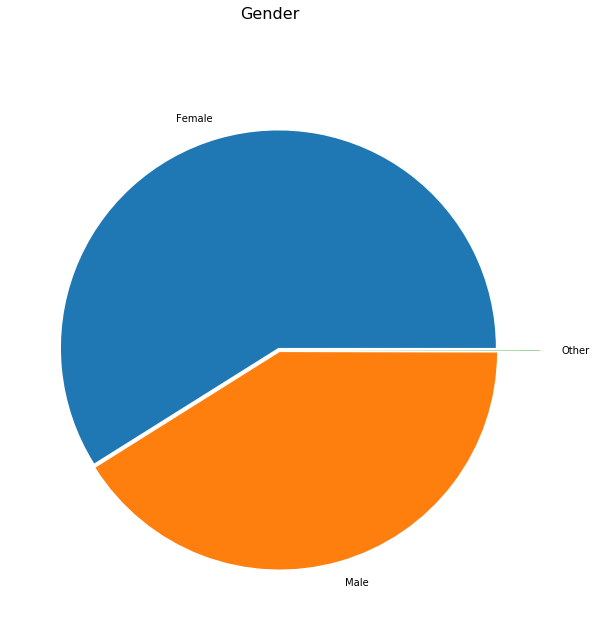

In [6]:
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Gender', fontsize=16)
plt.pie(train.gender.value_counts(), labels=['Female', 'Male', 'Other'], explode=(0.01, 0.01, 0.2)) 
plt.show()

Видим, что есть три пола, хоть и "Other" почти отсутствует, "Male" меньше, чем "Female", но в мире наоборот мужской части населения больше, чем женской.

In [7]:
train.hypertension.value_counts()

0    27165
1     2836
Name: hypertension, dtype: int64

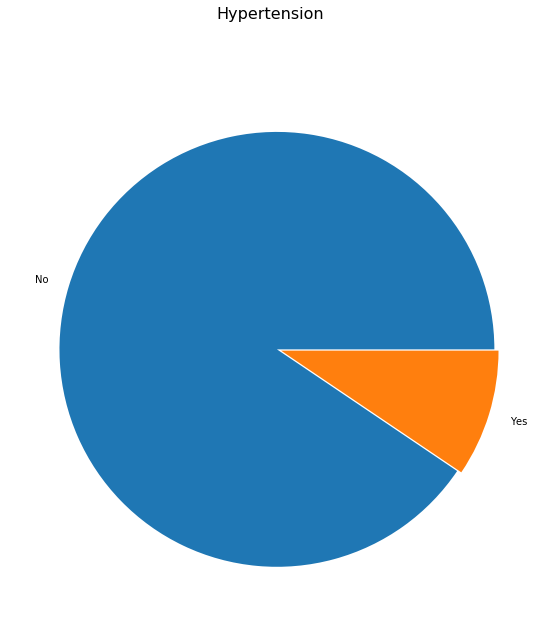

In [8]:
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Hypertension', fontsize=16)
plt.pie(train.hypertension.value_counts(), labels=['No', 'Yes'], explode=(0.01, 0.01)) 
plt.show()

По диаграмме мы можем сделать вывод, что гипертонией страдают около 10%, а в мире 16-30%

In [9]:
train.heart_disease.value_counts()

0    28566
1     1435
Name: heart_disease, dtype: int64

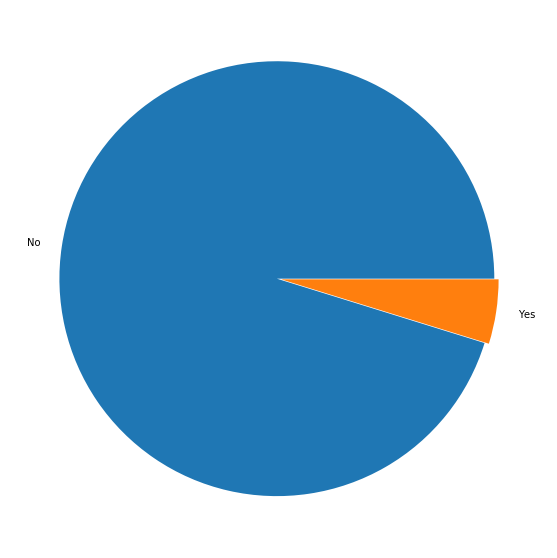

In [10]:
plt.figure(figsize=(10, 10))
fig.suptitle('Heart disease', fontsize=16)
plt.pie(train.heart_disease.value_counts(), labels=['No', 'Yes'], explode=(0.01, 0.01)) 
plt.show()

Здесь видно что около 5% страдают от сердечной не достаточности

In [11]:
train.ever_married.value_counts()

Yes    19376
No     10625
Name: ever_married, dtype: int64

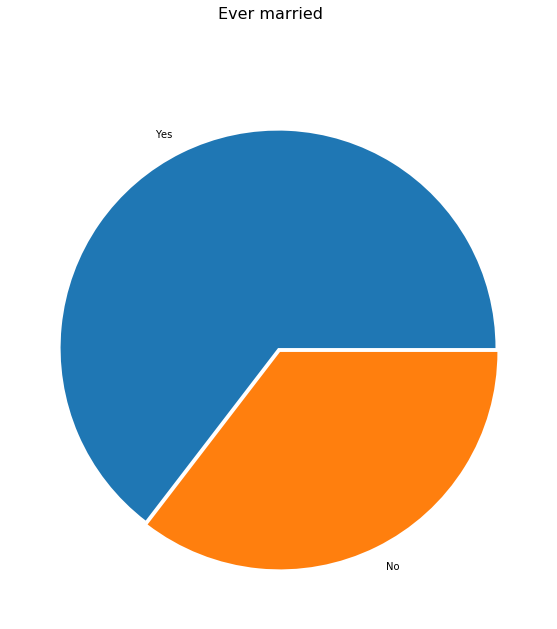

In [12]:
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Ever married', fontsize=16)
plt.pie(train.ever_married.value_counts(), labels=['Yes', 'No'], explode=(0.01, 0.01)) 
plt.show()

Тут мы видем что 2/3 опрошенных были женаты

In [13]:
train.work_type.value_counts()

Private          17220
Self-employed     4674
children          4188
Govt_job          3804
Never_worked       115
Name: work_type, dtype: int64

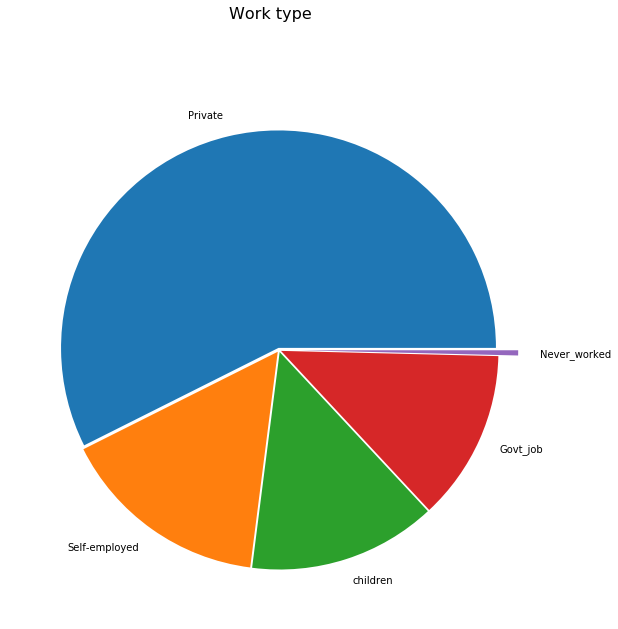

In [14]:
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Work type', fontsize=16)
plt.pie(train.work_type.value_counts(), labels=['Private', 'Self-employed', 'children', 'Govt_job', 
                                                'Never_worked'], explode=(0.01, 0.01, 0.01, 0.01, 0.1)) 
plt.show()

Тут разные трудоустроиности людей отображены

In [15]:
train.Residence_type.value_counts()

Urban    15028
Rural    14973
Name: Residence_type, dtype: int64

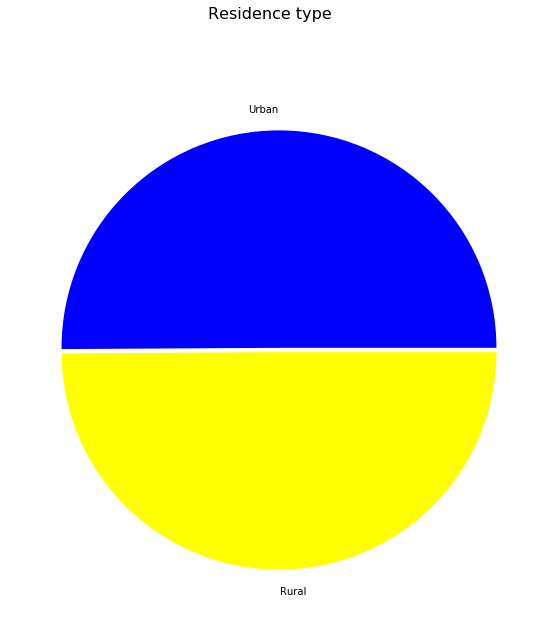

In [16]:
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Residence type', fontsize=16)
plt.pie(train.Residence_type.value_counts(), labels=['Urban', 'Rural'], explode=(0.01, 0.01), colors=['Blue', 'Yellow']) 
plt.show()

Отсюда мы видим, что около половины выборки живет в сельской местности, а другая в городе, и казалось бы причем тут Украина

In [17]:
train['smoking_status'] = train['smoking_status'].fillna('no data')
test['smoking_status'] = test['smoking_status'].fillna('no data')
train.smoking_status.value_counts()

never smoked       11079
no data             9176
formerly smoked     5183
smokes              4563
Name: smoking_status, dtype: int64

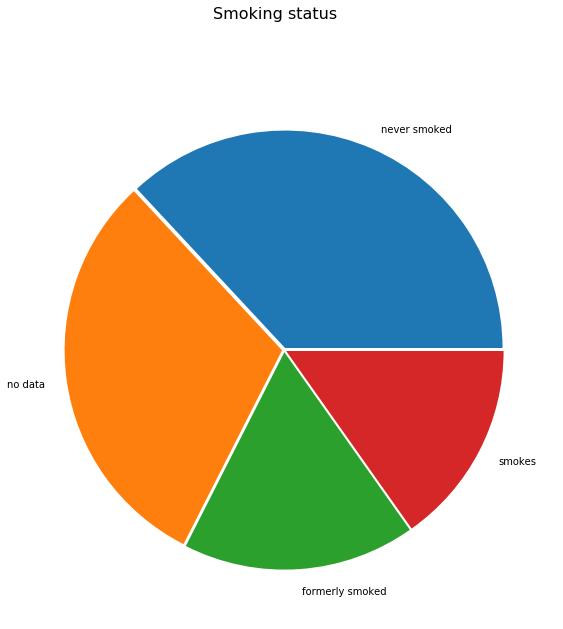

In [18]:
labels = list(['never smoked', 'no data', 'formerly smoked', 'smokes'])
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Smoking status', fontsize=16)
plt.pie(train.smoking_status.value_counts(), labels=labels,
        explode=(0.01, 0.01, 0.01, 0.01)) 
plt.show()

Тут мы видим что у нас много отсутствующей информации

А теперь посмотрим распределение числовых данных, для начала добавим среднее значение bmi к Nan.

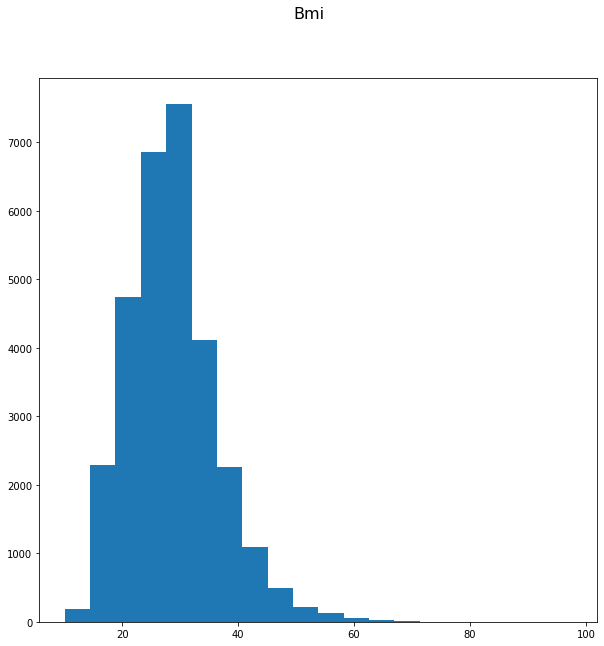

In [19]:
mean_bmi = train['bmi'].mean()
train['bmi'] = train['bmi'].fillna(mean_bmi)
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Bmi', fontsize=16)
plt.hist(train.bmi.values,bins=20) 
plt.show()

ИМТ лежит в основном между 20 и 30

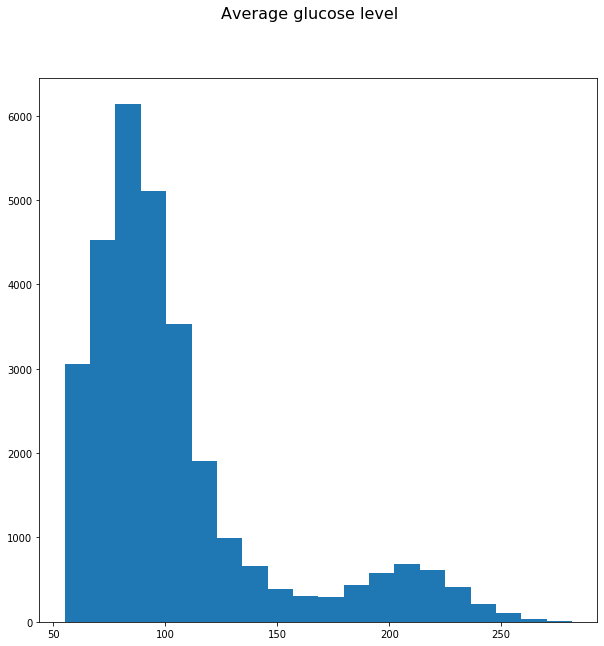

In [20]:
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Average glucose level', fontsize=16)
plt.hist(train.avg_glucose_level.values,bins=20) 
plt.show()

Хоть мы и не знаем единицы измерения глюкозы в крови, но обычно это мг/л, и по данным из вики норма это 72-99, если больше то у человека диабет((

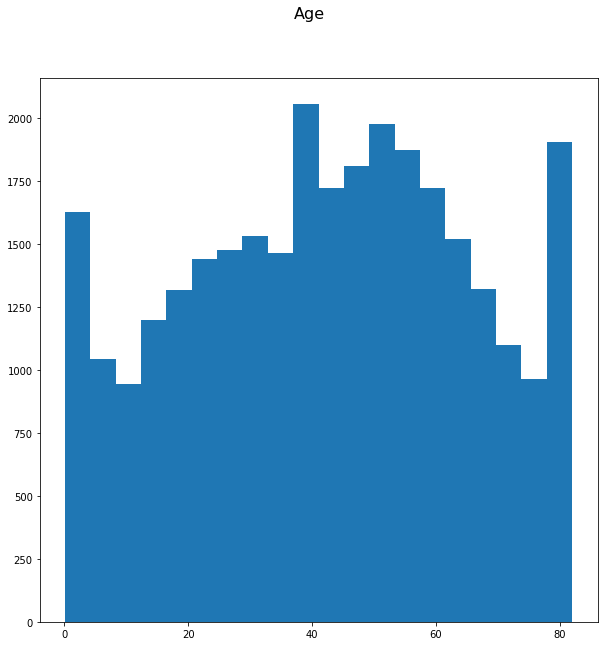

In [21]:
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Age', fontsize=16)
plt.hist(train.age.values,bins=20) 
plt.show()

Из этой диаграммы мы видем что в основном у нас данные о людях которым 40-50

## Feature generation

Для начала добавим средний ИМТ в тестовый датасет

In [0]:
test['bmi'] = test['bmi'].fillna(mean_bmi) # замещение Nan

Ну и заменим все да/нет на 1/0

In [0]:
ever_married_dict = {'Yes': 1, 'No':0 }
train['ever_married'] =train['ever_married'].replace(ever_married_dict)
test['ever_married'] = test['ever_married'].replace(ever_married_dict)

Проделаем нечто похожее с данными про работу, где 1-i это если мы знаем что то и 0 если нет

In [0]:
for i in train['work_type'].unique():
    train['work_type_is_{}'.format(i)] = (train['work_type'] == i)*1
    test['work_type_is_{}'.format(i)] = (test['work_type'] == i)*1

Тут замения знания о курильщиках на средние значения количества инсультов на тип курильщика

In [0]:
smoking_status_target_enc_dict = (train.groupby(['smoking_status'])['stroke'].agg(['mean'])).to_dict()['mean']
train['smoking_status_target_enc'] = train['smoking_status'].replace(smoking_status_target_enc_dict)
test['smoking_status_target_enc'] = test['smoking_status'].replace(smoking_status_target_enc_dict)
for i in train['smoking_status'].unique():
    train['smoking_status_is_{}'.format(i)] = (train['smoking_status'] == i)*1
    test['smoking_status_is_{}'.format(i)] = (test['smoking_status'] == i)*1

Так же оцифруем знание место проживания

In [0]:
residence_target_enc_dict = (train.groupby(['Residence_type'])['stroke'].agg(['mean'])).to_dict()['mean']
train['residence_target_enc'] = train['Residence_type'].replace(residence_target_enc_dict)
test['residence_target_enc'] = test['Residence_type'].replace(residence_target_enc_dict)
train['Residence_type'] = train['Residence_type'].replace({'Urban':0, 'Rural':1 })
test['Residence_type'] = test['Residence_type'].replace({'Urban':0, 'Rural':1 })

А теперь получим средние количество инсультов на половую принадлежность и добавим категориальные столбцы

In [0]:
gender_target_enc_dict = (train.groupby(['gender'])['stroke'].agg(['mean'])).to_dict()['mean']
train['gender_target_enc'] = train['gender'].replace(gender_target_enc_dict)
test['gender_target_enc'] = test['gender'].replace(gender_target_enc_dict)
for i in train['gender'].unique():
    train['gender_is_{}'.format(i)] = (train['gender'] == i)*1
    test['gender_is_{}'.format(i)] = (test['gender'] == i)*1

Посмотрим на корреляционную таблицу еще раз

In [28]:
cor = train.corr()
cor.style.background_gradient(cmap='coolwarm')

,id,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_is_children,work_type_is_Private,work_type_is_Never_worked,work_type_is_Self-employed,work_type_is_Govt_job,smoking_status_target_enc,smoking_status_is_no data,smoking_status_is_never smoked,smoking_status_is_formerly smoked,smoking_status_is_smokes,residence_target_enc,gender_target_enc,gender_is_Male,gender_is_Female,gender_is_Other
id,1,0.0134422,0.00982343,0.00682854,0.0103896,-0.00292922,0.0221249,0.0172642,0.00736639,-0.0231707,0.0104678,0.0030009,0.00890824,-0.00168967,0.016353,-0.018663,0.00730014,0.00901506,0.00464516,0.00292922,-0.00228787,-0.00212938,0.00209269,0.000981793
age,0.0134422,1,0.274369,0.25277,0.689001,-0.00379178,0.234806,0.349115,0.152684,-0.638318,0.139042,-0.0672996,0.323558,0.118051,0.371383,-0.374952,0.106128,0.24249,0.0831952,0.00379178,-0.0268858,-0.0286153,0.0287619,-0.00404646
hypertension,0.00982343,0.274369,1,0.121906,0.177805,0.00355456,0.161272,0.153921,0.0734252,-0.129489,-0.00202975,-0.0181993,0.108435,0.0230801,0.117109,-0.11854,0.0339235,0.0762624,0.0262241,-0.00355456,0.024683,0.0240546,-0.0238327,-0.00590001
heart_disease,0.00682854,0.25277,0.121906,1,0.126129,0.00369086,0.149709,0.0570828,0.101548,-0.0893774,-0.00526293,-0.0139032,0.102257,-0.00795716,0.094484,-0.0592878,-0.0346053,0.082667,0.0355527,-0.00369086,0.0789185,0.080314,-0.0801523,-0.00409266
ever_married,0.0103896,0.689001,0.177805,0.126129,1,-0.0037969,0.151777,0.339788,0.0696781,-0.543941,0.155254,-0.0781295,0.1932,0.13975,0.29752,-0.322222,0.0949776,0.170825,0.105967,0.0037969,-0.0310325,-0.0332356,0.0334381,-0.00556847
Residence_type,-0.00292922,-0.00379178,0.00355456,0.00369086,-0.0037969,1,0.00493958,0.00268303,-0.00279046,0.00381615,-0.00286013,-0.00474096,0.00225812,-0.00130489,-4.29609e-05,0.00613607,-0.00308652,0.00639257,-0.0104546,-1,-0.00111611,-0.000299716,0.000162936,0.00368551
avg_glucose_level,0.0221249,0.234806,0.161272,0.149709,0.151777,0.00493958,1,0.181794,0.0874264,-0.111774,0.0099759,-0.0140917,0.0796244,0.0174259,0.104047,-0.0944188,0.0123528,0.0744069,0.0262169,-0.00493958,0.0346896,0.0340443,-0.0337708,-0.00725969
bmi,0.0172642,0.349115,0.153921,0.0570828,0.339788,0.00268303,0.181794,1,0.0184937,-0.450905,0.191899,-0.0189874,0.0844988,0.095882,0.230895,-0.271248,0.108983,0.119922,0.0753261,-0.00268303,-0.0224725,-0.0228507,0.0228015,0.00124868
stroke,0.00736639,0.152684,0.0734252,0.101548,0.0696781,-0.00279046,0.0874264,0.0184937,1,-0.0525561,0.00398609,-0.0083187,0.0470445,-0.000913844,0.0417432,-0.0313579,-0.00247592,0.0350963,0.00661584,0.00279046,0.0102607,0.0100003,-0.00990826,-0.00244875
work_type_is_children,-0.0231707,-0.638318,-0.129489,-0.0893774,-0.543941,0.00381615,-0.111774,-0.450905,-0.0525561,1,-0.467539,-0.0249861,-0.173036,-0.153489,-0.39812,0.51538,-0.236071,-0.16601,-0.169256,-0.00381615,0.0895023,0.0916739,-0.0915853,-0.00208623


Из этой матрицы корреляции можно видеть, что существует прямая корреляция между Residence_target_enc и типом места жительства, что очевидно, поскольку один признак является производным от другого. Также существует сильная корреляция и статуса брака, и курения. Кроме того, ясно видно, что если функция получена из другого (например, Smoking_status_is ... и Smoking_status_enc_dict), корреляция наблюдается.

Давайте посмотрим на финальную таблицу

In [29]:
train.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,work_type_is_children,work_type_is_Private,work_type_is_Never_worked,work_type_is_Self-employed,work_type_is_Govt_job,smoking_status_target_enc,smoking_status_is_no data,smoking_status_is_never smoked,smoking_status_is_formerly smoked,smoking_status_is_smokes,residence_target_enc,gender_target_enc,gender_is_Male,gender_is_Female,gender_is_Other
0,30669,Male,3.0,0,0,0,children,1,95.12,18.0,no data,0,1,0,0,0,0,0.011443,1,0,0,0,0.017298,0.019245,1,0,0
1,30468,Male,58.0,1,0,1,Private,0,87.96,39.2,never smoked,0,0,1,0,0,0,0.017240,0,1,0,0,0.018033,0.019245,1,0,0
2,16523,Female,8.0,0,0,0,Private,0,110.89,17.6,no data,0,0,1,0,0,0,0.011443,1,0,0,0,0.018033,0.016576,0,1,0
3,56543,Female,70.0,0,0,1,Private,1,69.04,35.9,formerly smoked,0,0,1,0,0,0,0.027783,0,0,1,0,0.017298,0.016576,0,1,0
4,46136,Male,14.0,0,0,0,Never_worked,1,161.28,19.1,no data,0,0,0,1,0,0,0.011443,1,0,0,0,0.017298,0.019245,1,0,0


## Выбор оптимальных гиперпарметров для модели


Для начала поделим тренировочные данные 80:20 для того чтоб были тестовые данные

In [0]:
res = train['stroke']
X_train, X_test, Y_train, Y_test = train_test_split(train, res, test_size=0.2)

Теперь напишем кросс-валидационную функцию, которая возвращает коэф ROC-AUC

In [0]:
def my_cross_validation_for_roc_auc(clf, X, y ,cv=5):
    X = np.array(X.copy())
    y = np.array(y.copy())
    kf = KFold(n_splits=cv)
    kf.get_n_splits(X)
    scores = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        prediction_on_this_fold = clf.predict_proba(X_test)[:,1]
        score = roc_auc_score(y_score=prediction_on_this_fold, y_true=y_test)
        scores.append(score)
    return scores

In [0]:
features = ['id', 'age', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type', 'avg_glucose_level', 
            'bmi', 'work_type_is_children', 'work_type_is_Private', 'work_type_is_Never_worked',
            'work_type_is_Self-employed', 'work_type_is_Govt_job', 'smoking_status_target_enc',
            'smoking_status_is_no data', 'smoking_status_is_never smoked', 'smoking_status_is_formerly smoked',
            'smoking_status_is_smokes', 'residence_target_enc', 'gender_target_enc',  'gender_is_Male',
            'gender_is_Female', 'gender_is_Other']

### Logistic regression

Воспользуемся логистической регрессией

In [0]:
model = linear_model.SGDClassifier(max_iter=1000,  loss='log', penalty = 'elasticnet')

In [34]:
features_scores = {}
for f in features:
    scores = my_cross_validation_for_roc_auc(model, X_train[[f]] , Y_train)
    print(f,  np.mean(scores))
    features_scores[f] = np.mean(scores)

id 0.4998940398565944
age 0.8370423690515846
hypertension 0.5891200414426475
heart_disease 0.5878583104409214
ever_married 0.6266107563192003
Residence_type 0.4964339498148802
avg_glucose_level 0.5519332062776896
bmi 0.5150080500422297
work_type_is_children 0.5702191104563257
work_type_is_Private 0.5
work_type_is_Never_worked 0.501930652625575
work_type_is_Self-employed 0.5624973438066183
work_type_is_Govt_job 0.4897085436535088
smoking_status_target_enc 0.5727648764761625
smoking_status_is_no data 0.5470761597780159
smoking_status_is_never smoked 0.49533522204305547
smoking_status_is_formerly smoked 0.542317299094621
smoking_status_is_smokes 0.5005489109116945
residence_target_enc 0.5
gender_target_enc 0.5
gender_is_Male 0.4900550422871851
gender_is_Female 0.4970170671373693
gender_is_Other 0.5


Исходя из этих данных сузим список категорий

In [0]:
features = ['age', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type', 'avg_glucose_level', 
            'work_type_is_children', 'work_type_is_Self-employed', 'work_type_is_Govt_job', 'smoking_status_target_enc',
            'smoking_status_is_no data', 'smoking_status_is_never smoked', 'smoking_status_is_formerly smoked',
            'smoking_status_is_smokes', 'gender_is_Male', 'gender_is_Female']

А теперь выберем оптимальное раздение cv

In [36]:
for j in range(2, 20):
    scores = my_cross_validation_for_roc_auc(model, X_train[features] , Y_train, j)
    print(sum(scores) / len(scores), j)

0.8411560901825152 2
0.846992221180726 3
0.8403731870473908 4
0.8373466917675341 5
0.8386529294145838 6
0.8316800280540564 7
0.8411617888258641 8
0.843576057009173 9
0.8424855631091208 10
0.8412235468853786 11
0.8391510466175554 12
0.8403658439981542 13
0.844193479147349 14
0.8372621376141055 15
0.8433086464784526 16
0.8392428130213013 17
0.842015691494253 18
0.8395586421811473 19


Видно что оптимальнее всего делить на 10 частей

Теперь найдем оптимальные параметры для логистической регрессии, используя GridSearchCV.

In [37]:
model = linear_model.SGDClassifier(loss='log')
X_train = X_train[features]
parameters = { 
     "penalty"        : [ 'l2', 'l1', 'elasticnet'],
     "max_iter" : [ 100, 500, 1000, 1500, 2000, 2500]
        }
grid = GridSearchCV(model, parameters, n_jobs=12, scoring="roc_auc", cv=10, verbose=5)
grid.fit(X_train, Y_train)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    8.8s
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:   30.7s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:  1.0min
[Parallel(n_jobs=6)]: Done 180 out of 180 | elapsed:  1.2min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='log', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5,
                                     random_state=None, shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='warn', n_jobs=6,
             param_grid={'max_iter': [100, 500, 1000, 1500, 2000, 2500],
                         'penalty': ['l2', 'l1', 'elasticnet']},
             pre_dispatch='2*n_jobs', refit=True, return_train_sc

In [38]:
grid.best_estimator_ 

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=2000,
              n_iter_no_change=5, n_jobs=None, penalty='elasticnet',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

Выбираем лучшую оценку и тестируем ее на тренировочных данных, вычисление AUC

In [39]:
model = linear_model.SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=2500,
              n_iter_no_change=5, n_jobs=None, penalty='elasticnet',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
model.fit(X_train, Y_train)
X_test = X_test[features]
prediction = model.predict_proba(X_test)
print('Auc score for logistic regression:', roc_auc_score(y_score=prediction[:,1], y_true=Y_test))


Auc score for logistic regression: 0.8328218327447573


Предсказание на тестовых данных

In [0]:
res = model.predict_proba(test[features])

In [0]:
sample['stroke'] = res[:, 1]
sample.to_csv('submit_log_reg.csv', index = None )

### Random forrest классификатор

In [0]:
features = ['age', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type', 'avg_glucose_level', 
            'bmi', 'work_type_is_children', 'work_type_is_Private', 'work_type_is_Never_worked',
            'work_type_is_Self-employed', 'work_type_is_Govt_job', 'smoking_status_target_enc',
            'smoking_status_is_no data', 'smoking_status_is_never smoked', 'smoking_status_is_formerly smoked',
            'smoking_status_is_smokes', 'gender_target_enc',  'gender_is_Male', 'gender_is_Female', 'gender_is_Other']

In [0]:
res = train['stroke']
X_train, X_test, Y_train, Y_test = train_test_split(train, res, test_size=0.2)

Поиск категорий с наибольшим влиянием. Категории малого влияния и с большой корреляцией будет удалены

In [44]:
model = RandomForestClassifier()
features_scores = {}
for f in features:
    scores = my_cross_validation_for_roc_auc(model, X_train[[f]] , Y_train)
    print(f,  np.mean(scores))
    features_scores[f] = np.mean(scores)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


age 0.8259587083523856
hypertension 0.5710436319463519
heart_disease 0.5868946047820881
ever_married 0.631449644323062
Residence_type 0.5108024910924021
avg_glucose_level 0.5069789577337879
bmi 0.588301052937293
work_type_is_children 0.5703405619480618
work_type_is_Private 0.49410754774762433
work_type_is_Never_worked 0.5020149609356881
work_type_is_Self-employed 0.5677083557993987
work_type_is_Govt_job 0.48104228786754905
smoking_status_target_enc 0.5798808132312826
smoking_status_is_no data 0.5519443054391562
smoking_status_is_never smoked 0.49112049446224726
smoking_status_is_formerly smoked 0.5472854120696575
smoking_status_is_smokes 0.5095237928325178
gender_target_enc 0.5300777411092775
gender_is_Male 0.5299778523432049
gender_is_Female 0.5297868909369224
gender_is_Other 0.5001909614062823


In [45]:
features = ['age', 'hypertension', 'heart_disease', 'ever_married', 'work_type_is_children',
            'work_type_is_Self-employed', 'smoking_status_target_enc', 'gender_target_enc']
X_train, X_test, Y_train, Y_test = train_test_split(train[features], train['stroke'], test_size=0.2)
cor = X_train.corr()
cor.style.background_gradient(cmap='coolwarm')

,age,hypertension,heart_disease,ever_married,work_type_is_children,work_type_is_Self-employed,smoking_status_target_enc,gender_target_enc
age,1,0.274645,0.252877,0.689006,-0.642641,0.323787,0.374946,-0.0298474
hypertension,0.274645,1,0.116195,0.175023,-0.13033,0.107784,0.119207,0.0191544
heart_disease,0.252877,0.116195,1,0.12362,-0.0896001,0.105823,0.092793,0.0752309
ever_married,0.689006,0.175023,0.12362,1,-0.547262,0.191882,0.299875,-0.0298926
work_type_is_children,-0.642641,-0.13033,-0.0896001,-0.547262,1,-0.174717,-0.401553,0.0899333
work_type_is_Self-employed,0.323787,0.107784,0.105823,0.191882,-0.174717,1,0.11159,-0.00366603
smoking_status_target_enc,0.374946,0.119207,0.092793,0.299875,-0.401553,0.11159,1,-0.00396815
gender_target_enc,-0.0298474,0.0191544,0.0752309,-0.0298926,0.0899333,-0.00366603,-0.00396815,1


Удаляем информацию о браке, так как она сильно коррелирует с возрастом, а он важнее

In [0]:
features = ['age', 'hypertension', 'heart_disease', 'work_type_is_children',
            'work_type_is_Self-employed', 'smoking_status_target_enc', 'gender_target_enc']
X_train, X_test, Y_train, Y_test = train_test_split(train[features], train['stroke'], test_size=0.2)

Поиск гиперпараметров для модели, возврат их и тестирование на тренировочных данных, прогназирование на тестовых данных

In [47]:
model = RandomForestClassifier()
parameters = {
    "n_estimators" :[10, 25, 50, 100, 150],
    "criterion" :['gini', 'entropy'],
    "max_depth" :[1, 3, 5, 7, 9, None],
    "min_samples_split" :[2, 4, 10, 20],
    "min_samples_leaf" :[1, 3, 5, 7],
    "max_features" :['auto', 'sqrt', 'log2', None]
    
        }
grid = GridSearchCV(model, parameters, n_jobs=14, scoring="roc_auc", cv=3, verbose=5)
grid.fit(X_train, Y_train)

Fitting 3 folds for each of 3840 candidates, totalling 11520 fits


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  44 tasks      | elapsed:   21.5s
[Parallel(n_jobs=14)]: Done 134 tasks      | elapsed:   39.8s
[Parallel(n_jobs=14)]: Done 260 tasks      | elapsed:  1.1min
[Parallel(n_jobs=14)]: Done 422 tasks      | elapsed:  1.6min
[Parallel(n_jobs=14)]: Done 620 tasks      | elapsed:  2.3min
[Parallel(n_jobs=14)]: Done 854 tasks      | elapsed:  3.2min
[Parallel(n_jobs=14)]: Done 1124 tasks      | elapsed:  4.2min
[Parallel(n_jobs=14)]: Done 1430 tasks      | elapsed:  5.5min
[Parallel(n_jobs=14)]: Done 1772 tasks      | elapsed:  7.1min
[Parallel(n_jobs=14)]: Done 2150 tasks      | elapsed:  9.2min
[Parallel(n_jobs=14)]: Done 2564 tasks      | elapsed: 11.1min
[Parallel(n_jobs=14)]: Done 3014 tasks      | elapsed: 13.9min
[Parallel(n_jobs=14)]: Done 3500 tasks      | elapsed: 16.4min
[Parallel(n_jobs=14)]: Done 4022 tasks      | elapsed: 20.1min
[Parallel(n_jobs=14)]: Done 4580 tasks      | e

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=Fa...
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid=

In [59]:
grid.best_estimator_

AttributeError: ignored

In [60]:
model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
model.fit(X_train, Y_train)
X_test = X_test[features]
prediction = model.predict_proba(X_test)
print('Auc score for Random Forrest Classifier:', roc_auc_score(y_score=prediction[:,1], y_true=Y_test))

Auc score for Random Forrest Classifier: 0.8414854226224955


In [0]:
res = model.predict_proba(test[features])
sample['stroke'] = res[:, 1]
sample.to_csv('submit_ran_for.csv', index = None )

### XGBoost

In [0]:
features = ['id', 'age', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type', 'avg_glucose_level', 
            'bmi', 'work_type_is_children', 'work_type_is_Private', 'work_type_is_Never_worked',
            'work_type_is_Self-employed', 'work_type_is_Govt_job', 'smoking_status_target_enc',
            'smoking_status_is_no data', 'smoking_status_is_never smoked', 'smoking_status_is_formerly smoked',
            'smoking_status_is_smokes', 'residence_target_enc', 'gender_target_enc',  'gender_is_Male',
            'gender_is_Female', 'gender_is_Other']
X_train, X_test, Y_train, Y_test = train_test_split(train[features], train['stroke'], test_size=0.2)

Поиск наболее важных параметров для классификации

In [0]:
param = {
    'eta': 0.3, 
    'max_depth': 3,  
    'objective': 'binary:logistic'}

In [0]:
model = XGBClassifier(**param)

In [65]:
features_scores = {}
for f in features:
    scores = my_cross_validation_for_roc_auc(model, X_train[[f]] , Y_train)
    print(f,  np.mean(scores))
    features_scores[f] = np.mean(scores)

id 0.492397536429927
age 0.8343669392767789
hypertension 0.5769142288978212
heart_disease 0.5799648481363601
ever_married 0.6268040534244377
Residence_type 0.4917532334860054
avg_glucose_level 0.6100412124215013
bmi 0.6052993232867667
work_type_is_children 0.5700970467090503
work_type_is_Private 0.48795638971764854
work_type_is_Never_worked 0.5019941985682947
work_type_is_Self-employed 0.5658366001155842
work_type_is_Govt_job 0.5043120208994123
smoking_status_target_enc 0.581145169465852
smoking_status_is_no data 0.5524176441684586
smoking_status_is_never smoked 0.5048916450624776
smoking_status_is_formerly smoked 0.5488221677261751
smoking_status_is_smokes 0.5084871215047612
residence_target_enc 0.4917532334860054
gender_target_enc 0.5166460527093677
gender_is_Male 0.5166460527093677
gender_is_Female 0.5164553235430386
gender_is_Other 0.5


Оставляем только уместных категорий

In [0]:
features = ['age', 'hypertension', 'heart_disease', 'ever_married', 'avg_glucose_level', 
            'bmi', 'work_type_is_children', 'work_type_is_Private', 'work_type_is_Self-employed',
            'smoking_status_target_enc', 'gender_target_enc']
X_train, X_test, Y_train, Y_test = train_test_split(train[features], train['stroke'], test_size=0.2)

Поиск лучшего оценщика, возврат его параметров и использование его для предсказания на тестовых данных

In [0]:
model = XGBClassifier(objective='binary:logistic', eval_metric='auc')

In [0]:
parameters = {
     "eta"    : [0.10, 0.15, 0.20] ,
     "max_depth"        : [ 5, 6, 8],
     "min_child_weight" : [ 3, 5, 7 ],
     "subsample": [1, 0.5],
     "gamma"            : [ 0.2, 0.3, 0.4 ],
     "colsample_bytree" : [ 0.4, 0.5, 0.7 ],
     }

In [72]:
grid = RandomizedSearchCV(model, parameters, n_jobs=14, n_iter = 250, scoring="roc_auc", cv=5, verbose=5)
grid.fit(X_train, Y_train)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  44 tasks      | elapsed:  1.0min
[Parallel(n_jobs=14)]: Done 134 tasks      | elapsed:  2.4min
[Parallel(n_jobs=14)]: Done 260 tasks      | elapsed:  4.3min
[Parallel(n_jobs=14)]: Done 422 tasks      | elapsed:  7.0min
[Parallel(n_jobs=14)]: Done 620 tasks      | elapsed: 10.1min
[Parallel(n_jobs=14)]: Done 854 tasks      | elapsed: 13.6min
[Parallel(n_jobs=14)]: Done 1124 tasks      | elapsed: 18.0min
[Parallel(n_jobs=14)]: Done 1250 out of 1250 | elapsed: 19.9min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1,
                                           eval_metric='auc', gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_s...
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='warn', n_iter=250,

In [73]:
grid.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, eta=0.1,
              eval_metric='auc', gamma=0.3, learning_rate=0.1, max_delta_step=0,
              max_depth=5, min_child_weight=7, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=0.5, verbosity=1)

In [75]:
model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, eta=0.1,
              eval_metric='auc', gamma=0.3, learning_rate=0.1, max_delta_step=0,
              max_depth=5, min_child_weight=7, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=0.5, verbosity=1)

model.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, eta=0.1,
              eval_metric='auc', gamma=0.3, learning_rate=0.1, max_delta_step=0,
              max_depth=5, min_child_weight=7, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=0.5, verbosity=1)

In [83]:
X_test = X_test[features]
prediction = model.predict_proba(X_test)
print('Auc score for XGBoost:', roc_auc_score(y_score=prediction[:, 1], 
                                              y_true=Y_test))

Auc score for XGBoost: 0.8448330791391289


In [0]:
res = model.predict_proba(test[features])
sample['stroke'] = res[:, 1]
sample.to_csv('submit_xgboost.csv', index = None )

Заметочка

Мы иследовали какие факторы влияют на возникнования инсульта, по статистике умных сайтов основными рисками:
гипертония;
холестерин крови;
диабет;
ожирение;
курение;
возраст;
болезни сердца;
стресс(брак, работа и все тягости нашей интересной и веселой жизни);

Для исследования я использовал 3 метода и они показали сие результаты:

Логистическая регрессия: возраст, гипертония, вечная_женщина, сердечная болезнь, статус курения, avg_glucose_level, тип работы ... (дети и работающие не по найму);


Random forest: возраст, гипертония, вечно женатый (исключен из списка возможностей, поскольку тишина сильно коррелирует с возрастом), bmi, heart_disease, статус курения, avg_glucose_level, тип работы ... (дети и работающие не по найму);


XGBoost: возраст, гипертония, вечный брак, сердечная болезнь, статус курения, avg_glucose_level, тип работы ... (дети и работающие не по найму); Как можно видеть, особенности, которые представляют риски для инсульта из медицинских знаний, также преобладают в используемых моделях, хотя интересно, что ИМТ не оказал влияния на логистическую регрессию. Важность статуса брака и типа работы может быть объяснена тем, что обе эти вещи вызывают стресс, и чем старше человек, тем больший риск инсульта представляет стресс.

Отсюда мы видим, что предсказано плюс минус одно и тоже, но с разной точностью.

Как видно лучшим оказался XGBoost, как же это удивительно ;)